In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the train and test CSV files
train = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')
train=train[['text','ptext','index','label']]
test=test[['text','ptext','index','label']]
# Extract features (X) and labels (y) for train and test datasets
X_train = train[['text', 'ptext']]
y_train = train['label']

X_test = test[['text', 'ptext']]
y_test = test['label']


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame 'data' with a 'label_index' column containing label indices

# Split the data into training and test sets with stratified sampling
#X_training, X_validation, y_training, y_validation = train_test_split(
#    train[['text','ptext','index']],  # Features (TF-IDF vectors)
#    train[['label','index']],      # Target variable (label indices)
#    test_size=0.2,
#    stratify=train['label'],  # Ensure stratified sampling based on label indices
#    random_state=48  # Set a random seed for reproducibility
#)

# Merge X_train and y_train into the train DataFrame based on 'index' column
#training = X_training.merge(y_training )

# Merge X_test and y_test into the test DataFrame based on 'index' column
#valid = X_validation.merge(y_validation)

# Now, the 'train' and 'test' DataFrames are merged based on the 'index' column
#training.to_csv('/content/drive/MyDrive/training.csv')
#valid.to_csv('/content/drive/MyDrive/validation.csv')


In [2]:
import pandas as pd

# Load the train and test CSV files
train = pd.read_csv('/content/drive/My Drive/training.csv')
valid=pd.read_csv('/content/drive/My Drive/validation.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')
train=train[['text','ptext','index','label']]
valid=valid[['text','ptext','index','label']]
test=test[['text','ptext','index','label']]
# Extract features (X) and labels (y) for train and test datasets
X_train = train[['text', 'ptext']]
y_train = train['label']

X_valid=valid[['text', 'ptext']]
y_valid = valid['label']

X_test = test[['text', 'ptext']]
y_test = test['label']


# without preproccessing

In [3]:
from gensim.models import Word2Vec

# Combine all the sentences from the 'article1' and 'summary1' columns
train_sentences = X_train['text'].tolist()
# Convert the sentences to lists of words
train_sentences = [sentence.split() for sentence in train_sentences]

# Create a Word2Vec model
model = Word2Vec(train_sentences, vector_size=300, window=5, min_count=1, workers=4)

# Train the model
model.train(train_sentences, total_examples=model.corpus_count, epochs=30)

# Save the model
#model.save("word2vec.model")

(34972280, 44241360)

In [4]:
vocab_size = len(model.wv.key_to_index)

print(len(model.wv.key_to_index))

64594


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

oov_tok='<oov>'
oov_token=oov_tok
tokenizer = Tokenizer(oov_token=oov_tok)#,num_words = vocab_size)
#tokenizer = Tokenizer(num_words = vocab_size)

tokenizer.fit_on_texts(X_train['text'])
print(len(list(tokenizer.word_index.keys())))


21406


In [6]:
X_train['text_indices'] = tokenizer.texts_to_sequences(X_train['text'])
sequences = tokenizer.texts_to_sequences(X_train['text'])

word_index = tokenizer.word_index


<ipython-input-6-bac10b2cb6b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text_indices'] = tokenizer.texts_to_sequences(X_train['text'])


In [ ]:
len(X_train['text'][0])

1653

In [ ]:
len(sequences[0])

278

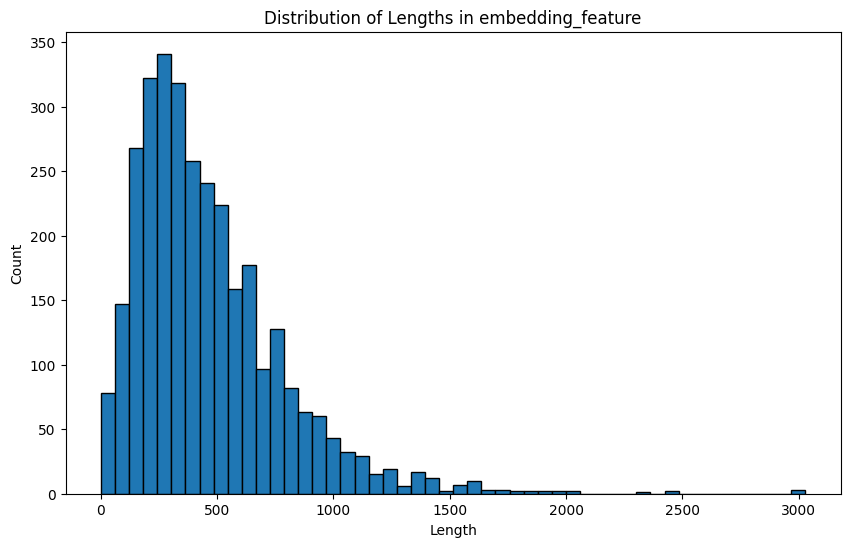

In [7]:
import matplotlib.pyplot as plt

lengths = [len(text.split()) for text in X_train['text']]
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Distribution of Lengths in embedding_feature')
plt.show()

In [8]:
import numpy as np

# Calculate the mean of lengths
mean_length = np.mean(lengths)

# Calculate the quartiles (25th, 50th, and 75th percentiles)
quartiles = np.percentile(lengths, [25, 50, 75])

print("Mean Length:", mean_length)
print("25th Percentile (1st Quartile):", quartiles[0])
print("50th Percentile (Median):", quartiles[1])
print("75th Percentile (3rd Quartile):", quartiles[2])


Mean Length: 464.1838212149827
25th Percentile (1st Quartile): 241.0
50th Percentile (Median): 393.0
75th Percentile (3rd Quartile): 614.0


In [9]:
word_vectors = model.wv
vocab_size = len(word_vectors.key_to_index)
num_words=len(word_vectors.key_to_index)

embedding_dim = model.vector_size
print(embedding_dim)


300


In [10]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#padding_type = 'post'  # Pad sequences at the end
#truncating_type = 'post'  # Truncate sequences at the end
#max_length = 200
# Padding sequences
#padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)


In [11]:
#X_test['text_indices'] = tokenizer.texts_to_sequences(X_test['text'])
#test_sequences = tokenizer.texts_to_sequences(X_test['text'])
#test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)


In [12]:
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from keras.models import Model
# encoder input model
max_length = 1000
inputs = Input(shape=(max_length,))
#encoder1 = Embedding(input_dim=num_words, output_dim=embedding_dim)(inputs)
encoder1 = Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[word_vectors.vectors], trainable=False)(inputs)
encoder2 = LSTM(256, return_sequences=True)(encoder1)  # Add return_sequences=True
# Bidirectional LSTM layer
encoder2_bilstm = Bidirectional(LSTM(128))(encoder2)

#outputs= Dense(5, activation='softmax')
# Define output layers for each sentiment column
output_layers = []
x=40
output_layer1 = Dense(128, activation='relu')(encoder2_bilstm)
output_layer2 = Dense(64, activation='relu')(output_layer1)
output_layer = Dense(x, activation='softmax')(output_layer2)
#output_layer = Dense(x, activation='softmax', name=col)(encoder2_bilstm) #label_encoder.classes_.shape[0]
output_layers.append(output_layer)

# Tie it together
model = Model(inputs=inputs, outputs=output_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 300)         19378200  
                                                                 
 lstm (LSTM)                 (None, 1000, 256)         570368    
                                                                 
 bidirectional (Bidirection  (None, 256)               394240    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Convert your text data to sequences and pad them
padding_type = 'post'  # Pad sequences at the end
truncating_type = 'post'  # Truncate sequences at the end
# Padding sequences
# Assuming you have already defined a tokenizer
input_column="text"
train_sequences = tokenizer.texts_to_sequences(X_train[input_column])
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
test_sequences = tokenizer.texts_to_sequences(X_test[input_column])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
valid_sequences = tokenizer.texts_to_sequences(X_valid[input_column])
valid_padded_sequences = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)


In [15]:
# Train the model
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with the EarlyStopping callback
history = model.fit(train_padded_sequences, y_train,
                    epochs=100, batch_size=512, validation_data=(valid_padded_sequences, y_valid),#validation_split=0.20,
                    callbacks=[early_stopping])

# Evaluate the model
results = model.evaluate(test_padded_sequences, y_test)



Epoch 1/100
7/7 [==============================] - 21s 1s/step - loss: 3.4175 - accuracy: 0.1813 - val_loss: 2.9968 - val_accuracy: 0.2503
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 2.8820 - accuracy: 0.2981 - val_loss: 2.7568 - val_accuracy: 0.3057
Epoch 3/100
7/7 [==============================] - 8s 1s/step - loss: 2.7179 - accuracy: 0.3138 - val_loss: 2.6498 - val_accuracy: 0.3384
Epoch 4/100
7/7 [==============================] - 8s 1s/step - loss: 2.6181 - accuracy: 0.3453 - val_loss: 2.5798 - val_accuracy: 0.3572
Epoch 5/100
7/7 [==============================] - 8s 1s/step - loss: 2.5309 - accuracy: 0.3573 - val_loss: 2.5197 - val_accuracy: 0.3409
Epoch 6/100
7/7 [==============================] - 8s 1s/step - loss: 2.4451 - accuracy: 0.3673 - val_loss: 2.4723 - val_accuracy: 0.3585
Epoch 7/100
7/7 [==============================] - 8s 1s/step - loss: 2.3701 - accuracy: 0.3780 - val_loss: 2.4213 - val_accuracy: 0.3421
Epoch 8/100
7/7 [================

In [16]:
print(results)

[2.3159573078155518, 0.3148893415927887]


In [23]:
# Get predictions from the model
test_probabilities = model.predict(test_padded_sequences)

# Find the predicted class labels using argmax
test_predictions = test_probabilities.argmax(axis=1)

# Create a DataFrame with a single column for predictions
test_predictions_df = pd.DataFrame({'predictions': test_predictions})

# Save the DataFrame to a CSV file
test_predictions_df.to_csv('/content/drive/MyDrive/bilsm.csv', index=False)


32/32 [==============================] - 2s 51ms/step


In [25]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 31.49%


# with preprocessing

In [26]:
from gensim.models import Word2Vec

# Combine all the sentences from the 'article1' and 'summary1' columns
train_sentences = X_train['ptext'].tolist()
# Convert the sentences to lists of words
train_sentences = [sentence.split() for sentence in train_sentences]

# Create a Word2Vec model
model = Word2Vec(train_sentences, vector_size=300, window=5, min_count=1, workers=4)

# Train the model
model.train(train_sentences, total_examples=model.corpus_count, epochs=30)

# Save the model
#model.save("word2vec.model")

(26879752, 28152660)

In [27]:
vocab_size = len(model.wv.key_to_index)

print(len(model.wv.key_to_index))

19276


In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

oov_tok='<oov>'
oov_token=oov_tok
tokenizer = Tokenizer(oov_token=oov_tok)#,num_words = vocab_size)
#tokenizer = Tokenizer(num_words = vocab_size)

tokenizer.fit_on_texts(X_train['ptext'])
print(len(list(tokenizer.word_index.keys())))


19277


In [29]:
X_train['ptext_indices'] = tokenizer.texts_to_sequences(X_train['ptext'])
sequences = tokenizer.texts_to_sequences(X_train['ptext'])

word_index = tokenizer.word_index


In [30]:
word_vectors = model.wv
vocab_size = len(word_vectors.key_to_index)
num_words=len(word_vectors.key_to_index)

embedding_dim = model.vector_size
print(embedding_dim)


300


In [35]:
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from keras.models import Model
# encoder input model
max_length = 512
inputs = Input(shape=(max_length,))
#encoder1 = Embedding(input_dim=num_words, output_dim=embedding_dim)(inputs)
encoder1 = Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[word_vectors.vectors], trainable=False)(inputs)
encoder2 = LSTM(512, return_sequences=True)(encoder1)  # Add return_sequences=True
# Bidirectional LSTM layer
encoder2_bilstm = Bidirectional(LSTM(256))(encoder2)

#outputs= Dense(5, activation='softmax')
# Define output layers for each sentiment column
output_layers = []
x=40
output_layer1 = Dense(128, activation='relu')(encoder2_bilstm)
output_layer2 = Dense(64, activation='relu')(output_layer1)
output_layer = Dense(x, activation='softmax')(output_layer2)
#output_layer = Dense(x, activation='softmax', name=col)(encoder2_bilstm) #label_encoder.classes_.shape[0]
output_layers.append(output_layer)

# Tie it together
model = Model(inputs=inputs, outputs=output_layers)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 512, 300)          5782800   
                                                                 
 lstm_4 (LSTM)               (None, 512, 512)          1665024   
                                                                 
 bidirectional_2 (Bidirecti  (None, 512)               1574912   
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                           

In [36]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Convert your text data to sequences and pad them
padding_type = 'post'  # Pad sequences at the end
truncating_type = 'post'  # Truncate sequences at the end
# Padding sequences
# Assuming you have already defined a tokenizer
input_column="ptext"
train_sequences = tokenizer.texts_to_sequences(X_train[input_column])
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
test_sequences = tokenizer.texts_to_sequences(X_test[input_column])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)
valid_sequences = tokenizer.texts_to_sequences(X_valid[input_column])
valid_padded_sequences = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=truncating_type)


In [ ]:
# Train the model
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with the EarlyStopping callback
history = model.fit(train_padded_sequences, y_train,
                    epochs=50, batch_size=512, validation_data=(valid_padded_sequences, y_valid),#validation_split=0.20,
                    callbacks=[early_stopping])

# Evaluate the model
results = model.evaluate(test_padded_sequences, y_test)



Epoch 1/50
7/7 [==============================] - 19s 2s/step - loss: 3.2366 - accuracy: 0.2043 - val_loss: 2.8812 - val_accuracy: 0.3031
Epoch 2/50
7/7 [==============================] - 13s 2s/step - loss: 2.7518 - accuracy: 0.3242 - val_loss: 2.6570 - val_accuracy: 0.3535
Epoch 3/50
7/7 [==============================] - 13s 2s/step - loss: 2.5839 - accuracy: 0.3516 - val_loss: 2.5194 - val_accuracy: 0.3535
Epoch 4/50
7/7 [==============================] - 13s 2s/step - loss: 2.4452 - accuracy: 0.3636 - val_loss: 2.4434 - val_accuracy: 0.3597
Epoch 5/50
7/7 [==============================] - 13s 2s/step - loss: 2.3167 - accuracy: 0.3783 - val_loss: 2.4134 - val_accuracy: 0.3560
Epoch 6/50


In [ ]:
print(results)

In [ ]:
# Get predictions from the model
test_probabilities = model.predict(test_padded_sequences)

# Find the predicted class labels using argmax
test_predictions = test_probabilities.argmax(axis=1)

# Create a DataFrame with a single column for predictions
test_predictions_df = pd.DataFrame({'predictions': test_predictions})

# Save the DataFrame to a CSV file
test_predictions_df.to_csv('/content/drive/MyDrive/bilsm_pp.csv', index=False)


# another

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# Encoder input model
max_length = 512
inputs = Input(shape=(max_length,))
num_classes = 40

output_layer1 = Dense(512, activation='relu')(inputs)
output_layer2 = Dropout(0.5)(output_layer1)
output_layer = Dense(num_classes, activation='softmax')(output_layer2)

# Tie it together
model = Model(inputs=inputs, outputs=output_layer)
model.summary()


# new columns

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
vectorizer=CountVectorizer(analyzer='word')
feature_space=vectorizer.fit_transform(list(df['transcription_lower']))
count_vect_df = pd.DataFrame(feature_space.todense(), columns=vectorizer.get_feature_names())
new_df=pd.concat([df, count_vect_df], axis=1)
new_df.head()